## Trade & Media Slant - LSTM Sentiment Analysis

Linghui Wu

In [1]:
# -*- coding: utf-8 -*-
from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn import metrics
import collections
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Exploratory Data Analysis
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
with open("../data/train.txt","r+") as f:
    for line in f:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            word_freqs[word] += 1
        num_recs += 1
print("Max Length: ", maxlen)
print("Number of words: ", len(word_freqs))

Max Length:  80
Number of words:  6561


In [3]:
# Data preparations
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}
X = np.empty(num_recs,dtype=list)
y = np.zeros(num_recs)
i = 0
with open("../data/train.txt","r+") as f:
    for line in f:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        seqs = []
        for word in words:
            if word in word2index:
                seqs.append(word2index[word])
            else:
                seqs.append(word2index["UNK"])
        X[i] = seqs
        y[i] = int(label)
        i += 1

X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Construct neural network
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [5]:
# Train the model
model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=(Xtest, ytest))

Train on 3528 samples, validate on 883 samples
Epoch 1/10
3528/3528 [==============================] - 3s 813us/step - loss: 0.6008 - accuracy: 0.6633 - val_loss: 0.4448 - val_accuracy: 0.7928
Epoch 2/10
3528/3528 [==============================] - 2s 598us/step - loss: 0.3089 - accuracy: 0.8739 - val_loss: 0.3324 - val_accuracy: 0.8437
Epoch 3/10
3528/3528 [==============================] - 2s 595us/step - loss: 0.1971 - accuracy: 0.9280 - val_loss: 0.3460 - val_accuracy: 0.8471
Epoch 4/10
3528/3528 [==============================] - 2s 687us/step - loss: 0.1529 - accuracy: 0.9461 - val_loss: 0.3993 - val_accuracy: 0.8313
Epoch 5/10
3528/3528 [==============================] - 2s 614us/step - loss: 0.1245 - accuracy: 0.9572 - val_loss: 0.4673 - val_accuracy: 0.8471
Epoch 6/10
3528/3528 [==============================] - 2s 598us/step - loss: 0.0949 - accuracy: 0.9646 - val_loss: 0.5000 - val_accuracy: 0.8550
Epoch 7/10
3528/3528 [==============================] - 2s 611us/step - loss:

In [6]:
# Prediction
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("\nTest score: %.3f, accuracy: %.3f" % (score, acc))
print("{}\t{}\t{}.".format("Predicted","True","Sentence"))
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1,40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([index2word[x] for x in xtest[0] if x != 0])
    print("{}\t\t{}\t\t{}".format(int(round(ypred)), int(ylabel), sent))

883/883 [==============================] - 0s 200us/step

Test score: 0.653, accuracy: 0.834
Predicted	True	Sentence.
1		1		the keyboard is really worthwhile in UNK and is sturdy enough i do n't expect any problems .
1		1		this really is how vegas fine dining used to be , right down to the menus UNK to the ladies that have no prices UNK .
0		0		terrible service !
0		0		then we UNK to UNK UNK for the da vinci code , which as expected , tom hanks sucks ass in that movie , but the dramatic last 2 minutes were good .
1		1		best buffet in town , for the price you can not beat it .


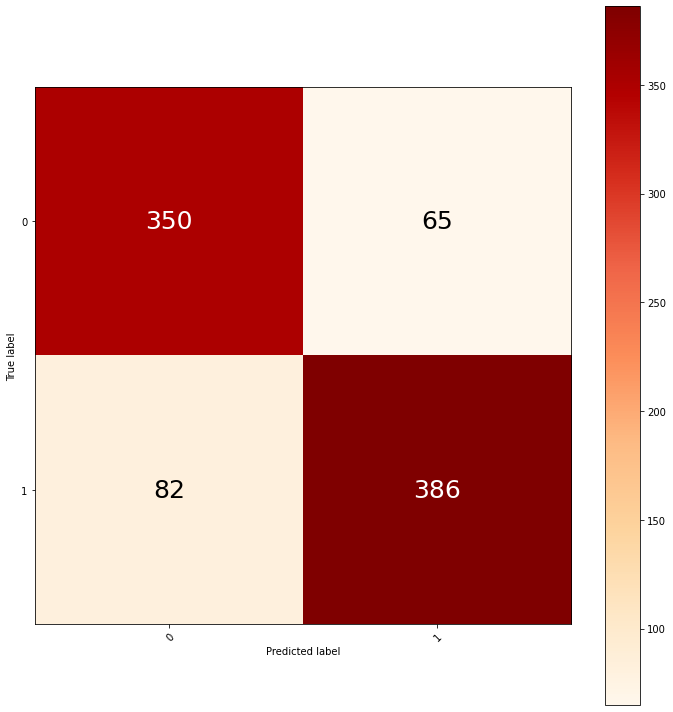

In [7]:
# Define a function that prints and plots the confusion matrix
def plot_confusion_matrix(cm, classes, cmap=plt.cm.OrRd):

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel="True label", xlabel="Predicted label")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]), fontsize=25, ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show();
    return ax


# Calculate and visualize the confusion matrix
ypred = model.predict(Xtest)
confusion_matrix = metrics.confusion_matrix(ytest, np.rint(ypred))
cm = np.array(confusion_matrix)
plot_confusion_matrix(cm, classes=range(2))

In [8]:
# Try self-input sentences
INPUT_SENTENCES = ['The book is boring.','Make American great again.']
XX = np.empty(len(INPUT_SENTENCES),dtype=list)
i = 0
for sentence in  INPUT_SENTENCES:
    words = nltk.word_tokenize(sentence.lower())
    seq = []
    for word in words:
        if word in word2index:
            seq.append(word2index[word])
        else:
            seq.append(word2index['UNK'])
    XX[i] = seq
    i += 1
XX = sequence.pad_sequences(XX, maxlen=MAX_SENTENCE_LENGTH)
labels = [int(round(x[0])) for x in model.predict(XX) ]
label2word = {1:"Positive", 0:"Negative"}
for i in range(len(INPUT_SENTENCES)):
    print('{}\t\t{}'.format(label2word[labels[i]], INPUT_SENTENCES[i]))

Negative		The book is boring.
Positive		Make American great again.


In [9]:
# Perform LSTM sentiment analysis on news
news = pd.read_excel("../data/news.xlsx")
news.head()

,title,abstract,content,publisher,year,sent_blob
0,"Arkansas Democrat-Gazette (Little Rock, AR)",No surprise,No one who has followed Saddam Hussein's caree...,Gazette,1998,0.125000
1,"Augusta Chronicle, The (GA)",ORIENTAL FLAVORS GROW ON CHINA GARDEN DINERS,"Mu Shu Pork, Moo Goo Gai Pan, Lobster Soon - i...",Augusta Chronicle,1998,0.114286
2,Bangor Daily News (ME),Khano Smith sparks MCI Huskies past Erskine,Khano Smith scored two goals and dished out an...,Daily News,1998,-0.135185
3,"Daily Tribune News, The (Cartersville, GA)",CHARLEY REESE,Columbus Day is one of my favorite holidays. I...,Tribune,1998,0.233333
4,"Flint Journal, The (MI)",WORLD REPORT,Italy: American arrested in sale of human orga...,Flint Journal,1998,-0.025000


In [10]:
articles = news["content"].values
XX = np.empty(len(articles),dtype=list)
i=0
for article in  articles:
    words = nltk.word_tokenize(article.lower())
    seq = []
    for word in words:
        if word in word2index:
            seq.append(word2index[word])
        else:
            seq.append(word2index['UNK'])
    XX[i] = seq
    i += 1
XX = sequence.pad_sequences(XX, maxlen=MAX_SENTENCE_LENGTH)
sent_lstm = [int(round(x[0])) for x in model.predict(XX)]
news["sent_lstm"] = sent_lstm
news.to_excel("../data/news.xlsx")